# Generate Heatmaps

In [1]:
import folium
from folium.plugins import MarkerCluster
from folium import IFrame,Popup
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import numpy as np
import pysal as ps

In [2]:
data = pd.read_csv("data/gross_rent_with_population.csv").sort_values(['Zip_Code', 'Samples'], ascending=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16580 entries, 0 to 16579
Data columns (total 14 columns):
State_Name    16580 non-null object
Place         16580 non-null object
Zip_Code      16580 non-null int64
ALand         16580 non-null int64
AWater        16580 non-null int64
Lat           16580 non-null float64
Lon           16580 non-null float64
Mean          16580 non-null int64
Median        16580 non-null int64
Stdev         16580 non-null int64
Samples       16580 non-null int64
Population    16580 non-null int64
City          16580 non-null object
County        16580 non-null object
dtypes: float64(2), int64(8), object(4)
memory usage: 1.9+ MB


In [3]:
geo_series = gpd.GeoSeries(data.apply(lambda z: Point(z['Lon'], z['Lat']) , 1), crs={'init': 'epsg:4326'})

geo_data = gpd.GeoDataFrame(data.drop(['Lon', 'Lat'], axis=1), geometry=geo_series).reset_index(drop=True)
geo_data.info()
geo_data.head(10)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16580 entries, 0 to 16579
Data columns (total 13 columns):
State_Name    16580 non-null object
Place         16580 non-null object
Zip_Code      16580 non-null int64
ALand         16580 non-null int64
AWater        16580 non-null int64
Mean          16580 non-null int64
Median        16580 non-null int64
Stdev         16580 non-null int64
Samples       16580 non-null int64
Population    16580 non-null int64
City          16580 non-null object
County        16580 non-null object
geometry      16580 non-null object
dtypes: int64(8), object(5)
memory usage: 1.6+ MB


,State_Name,Place,Zip_Code,ALand,AWater,Mean,Median,Stdev,Samples,Population,City,County,geometry
0,Alaska,Akutan city,99926,343946421,213611590,720,662,283,72,1460,Metlakatla,Prince Wales Ketchikan,POINT (-131.4704235 55.13835200000001)
1,Alaska,Hydaburg city,99922,1506300,5839,483,486,183,21,384,Hydaburg,Prince Wales Ketchikan,POINT (-132.818341 55.20412)
2,Alaska,Craig city,99921,18654310,6010703,1004,980,386,126,1920,Craig,Prince Wales Ketchikan,POINT (-133.111069 55.488233)
3,Alaska,Coffman Cove city,99918,30909225,9766357,802,795,40,15,231,Coffman Cove,Prince Wales Ketchikan,POINT (-132.841933 56.001751)
4,Alaska,Akutan city,99901,12523988591,4646176559,1255,1175,493,220,13508,Ketchikan,Ketchikan Gateway,POINT (-131.1066847 55.4499378)
5,Alaska,Lutak,99840,328819031,16325832,0,0,0,0,968,Skagway,Skagway Hoonah Angoon,POINT (-135.589046 59.412212)
6,Alaska,Akutan city,99835,17109651,32661843,1273,1129,555,117,8880,Sitka,Sitka,POINT (-135.3522511 57.0451454)
7,Alaska,Petersburg,99833,114295601,3884325,931,934,361,382,3202,Petersburg,Wrangell Petersburg,POINT (-132.873808 56.754283)
8,Alaska,Akutan city,99829,16962765542,7798365244,769,725,362,238,777,Hoonah,Skagway Hoonah Angoon,POINT (-135.513003 58.0735321)
9,Alaska,Klukwan,99827,3598502,1300463,669,736,170,5,2602,Haines,Haines,POINT (-135.886877 59.39976600000001)


In [4]:
# Combine data with the same place name
tmp = geo_data.reset_index(drop=True)
tmp = tmp.drop(["Zip_Code", "ALand", "AWater", "Median", "Stdev"], axis=1)
tmp.head()

,State_Name,Place,Mean,Samples,Population,City,County,geometry
0,Alaska,Akutan city,720,72,1460,Metlakatla,Prince Wales Ketchikan,POINT (-131.4704235 55.13835200000001)
1,Alaska,Hydaburg city,483,21,384,Hydaburg,Prince Wales Ketchikan,POINT (-132.818341 55.20412)
2,Alaska,Craig city,1004,126,1920,Craig,Prince Wales Ketchikan,POINT (-133.111069 55.488233)
3,Alaska,Coffman Cove city,802,15,231,Coffman Cove,Prince Wales Ketchikan,POINT (-132.841933 56.001751)
4,Alaska,Akutan city,1255,220,13508,Ketchikan,Ketchikan Gateway,POINT (-131.1066847 55.4499378)


In [5]:
# Pre-aggregate data on city level
tmp['totals'] = tmp['Mean'] * tmp['Samples']

In [6]:
# Read counties
counties = gpd.read_file("data/gz_2010_us_050_00_20m/gz_2010_us_050_00_20m.shp").set_index('GEO_ID', drop=False)
join_result = gpd.tools.sjoin(counties, tmp.to_crs(counties.crs), op='contains').reset_index()
join_result.head()
join_result.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16532 entries, 0 to 16531
Data columns (total 17 columns):
index          16532 non-null object
GEO_ID         16532 non-null object
STATE          16532 non-null object
COUNTY         16532 non-null object
NAME           16532 non-null object
LSAD           16532 non-null object
CENSUSAREA     16532 non-null float64
geometry       16532 non-null object
index_right    16532 non-null int64
State_Name     16532 non-null object
Place          16532 non-null object
Mean           16532 non-null int64
Samples        16532 non-null int64
Population     16532 non-null int64
City           16532 non-null object
County         16532 non-null object
totals         16532 non-null int64
dtypes: float64(1), int64(5), object(11)
memory usage: 2.1+ MB


In [7]:
# Multiply mean and Samples to be able to calculate the mean by county
sum_columns = join_result.groupby('GEO_ID').sum()
counties['Mean'] = (sum_columns['totals'] / sum_columns['Samples']).fillna(0)
counties['Population'] = (sum_columns['Population']).fillna(0)

In [8]:
counties['Population'] = counties['Population'].fillna(0)
counties['Mean'] = counties['Mean'].fillna(0)
counties.info()
counties.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3221 entries, 0500000US01001 to 0500000US51041
Data columns (total 9 columns):
GEO_ID        3221 non-null object
STATE         3221 non-null object
COUNTY        3221 non-null object
NAME          3221 non-null object
LSAD          3221 non-null object
CENSUSAREA    3221 non-null float64
geometry      3221 non-null object
Mean          3221 non-null float64
Population    3221 non-null float64
dtypes: float64(3), object(6)
memory usage: 251.6+ KB


,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,Mean,Population
index_left,,,,,,,,,
0500000US01001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.496774 32.344437, -86.7178969999...",1021.199622,38275.0
0500000US01009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.577799 33.765316, -86.7591439999...",624.894044,54010.0
0500000US01017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413099999999 32.870525, -85.12...",631.451598,37014.0
0500000US01021,0500000US01021,01,021,Chilton,County,692.854,"POLYGON ((-86.51734399999999 33.020566, -86.51...",637.531690,33633.0
0500000US01033,0500000US01033,01,033,Colbert,County,592.619,"POLYGON ((-88.139988 34.581703, -88.139246 34....",681.074384,52812.0


In [9]:
# classification
import sklearn
from sklearn.cluster import KMeans
%matplotlib inline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
counties = counties[counties['Mean'] > 0]
X = counties[["Population", "Mean"]]


(3063,)
For n_clusters=2, The Silhouette Coefficient is 0.946176621318


/Users/negarfazeli/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(3063,)
For n_clusters=3, The Silhouette Coefficient is 0.912048478525
(3063,)
For n_clusters=4, The Silhouette Coefficient is 0.877180436669
(3063,)
For n_clusters=5, The Silhouette Coefficient is 0.86609496324


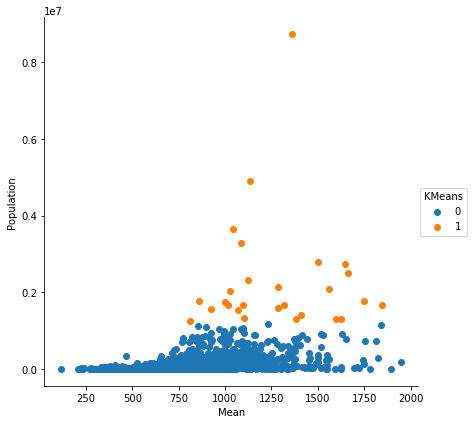

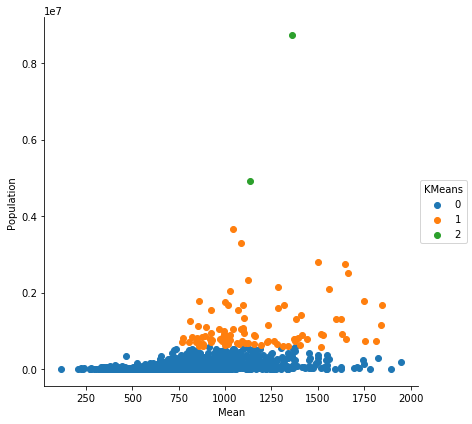

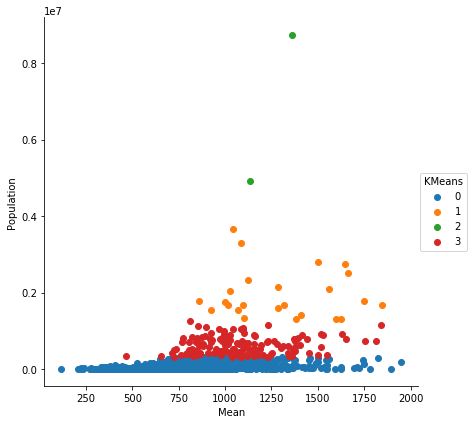

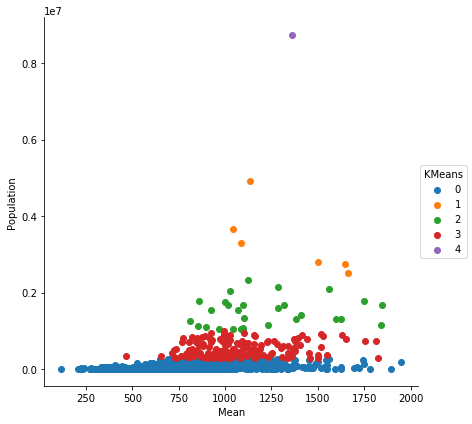

In [15]:
for n_cluster in range(2,6):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    print label.shape
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    X["KMeans"] = label.astype(np.int64)
    counties["KMeans_{}".format(n_cluster)] = label
    sns.FacetGrid(X, hue="KMeans", size=6) \
       .map(plt.scatter, "Mean", "Population" ) \
       .add_legend()

In [11]:
def add_choropleth(mapobj, gdf, id_field, value_field, legend_name, fill_color = 'YlOrRd', fill_opacity = 0.6, 
                    line_opacity = 0.2, num_classes = 5, classifier = 'Fisher_Jenks', clusters=None):
    #Allow for 3 Pysal map classifiers to display data
    #Generate list of breakpoints using specified classification scheme. List of breakpoint will be input to choropleth function
    if classifier == 'Fisher_Jenks':
        threshold_scale=ps.esda.mapclassify.Fisher_Jenks(gdf[value_field], k = num_classes).bins.tolist()
    if classifier == 'Equal_Interval':
        threshold_scale=ps.esda.mapclassify.Equal_Interval(gdf[value_field], k = num_classes).bins.tolist()
    if classifier == 'Quantiles':
        threshold_scale=ps.esda.mapclassify.Quantiles(gdf[value_field], k = num_classes).bins.tolist()
    if classifier == 'Percentiles':
        num_classes = 6
        threshold_scale=ps.esda.mapclassify.Percentiles(gdf[value_field], pct=[10, 50, 90, 99, 99.9, 100]).bins.tolist()
    if classifier == 'Jenks_Caspall':
        threshold_scale=ps.esda.mapclassify.Jenks_Caspall(gdf[value_field],  k = num_classes).bins.tolist()
    if classifier == 'Custom':
        threshold_scale=clusters
        num_classes=len(clusters)
    
    #Convert the GeoDataFrame to WGS84 coordinate reference system
    gdf_wgs84 = gdf.to_crs({'init': 'epsg:4326'})
    
    #Call Folium choropleth function, specifying the geometry as a the WGS84 dataframe converted to GeoJSON, the data as 
    #the GeoDataFrame, the columns as the user-specified id field and and value field.
    #key_on field refers to the id field within the GeoJSON string
    mapobj.choropleth(gdf_wgs84.to_json(), data = gdf,
                columns = [id_field, value_field], key_on = 'feature.properties.{}'.format(id_field),
                fill_color = fill_color, fill_opacity = fill_opacity, line_opacity = line_opacity,  
                threshold_scale = threshold_scale, legend_name = legend_name, highlight=False, smooth_factor=1.0)
    return mapobj

def add_point_clusters(mapobj, gdf, popup_field_list, layer_name):
    #Create empty lists to contain the point coordinates and the point pop-up information
    coords, popups = [], [] 
    #Loop through each record in the GeoDataFrame
    for i, row in gdf.iterrows():
        #Append lat and long coordinates to "coords" list
        coords.append([row.geometry.y, row.geometry.x])
        #Join together the fields in "popup_field_list" with a linebreak between them
        label = '<br>'.join(["{name}: {value}".format(name=field, value=str(row[field]) if type(row[field]) is str or type(row[field]) is int else "{:.1f}".format(row[field])) for field in popup_field_list])
        #Append an IFrame that uses the HTML string to the "popups" list 
        popups.append(Popup(label))
        
    #Create a Folium feature group for this layer, since we will be displaying multiple layers
    pt_lyr = folium.FeatureGroup(name = layer_name)
    
    #Add the clustered points of crime locations and popups to this layer
    pt_lyr.add_child(MarkerCluster(locations = coords, popups = popups))
    
    #Add this point layer to the map object
    mapobj.add_child(pt_lyr)
    return mapobj

In [16]:
for n_cluster in range(2,6):
    m = folium.Map(location=[48, -102], zoom_start=3, control_scale=True, prefer_canvas=False)
    clusters = range(n_cluster+1)
    m = add_choropleth(m, counties, 'GEO_ID', 'KMeans_{}'.format(n_cluster), legend_name='KMeans Cluster',\
                       classifier='Custom', num_classes=0, clusters=clusters)
#m = add_point_clusters(m, citywise_data, ['City','Population','Mean'], 'Mean Gross Rent per City')
    folium.LayerControl().add_to(m) #Add layer control to toggle on/off
    m.save("data/KMeans_{}.html".format(n_cluster))

In [14]:
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3063 entries, 0500000US01001 to 0500000US51041
Data columns (total 22 columns):
GEO_ID        3063 non-null object
STATE         3063 non-null object
COUNTY        3063 non-null object
NAME          3063 non-null object
LSAD          3063 non-null object
CENSUSAREA    3063 non-null float64
geometry      3063 non-null object
Mean          3063 non-null float64
Population    3063 non-null float64
KMeans_2      3063 non-null int32
KMeans_3      3063 non-null int32
KMeans_4      3063 non-null int32
KMeans_5      3063 non-null int32
KMeans_6      3063 non-null int32
KMeans_7      3063 non-null int32
KMeans_8      3063 non-null int32
KMeans_9      3063 non-null int32
KMeans_10     3063 non-null int32
KMeans_11     3063 non-null int32
KMeans_12     3063 non-null int32
KMeans_13     3063 non-null int32
KMeans_14     3063 non-null int32
dtypes: float64(3), int32(13), object(6)
memory usage: 474.8+ KB
